# 1D Helmholtz Multilevel Development: Repetitive + Alignment
* Constant $k$.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.

In [336]:
import collections
import logging
import numpy as np
import matplotlib.pyplot as plt
import helmholtz as hm
import helmholtz.repetitive.coarsening_repetitive as hrc
import pandas as pd
import scipy.sparse
import sklearn.metrics.pairwise
import sys
from numpy.ma.testutils import assert_array_almost_equal
from scipy.linalg import eig, norm, svd
from scipy.sparse.linalg import eigs
from scipy import optimize

%load_ext autoreload
%autoreload 2

np.set_printoptions(linewidth=500, precision=3, suppress=True, threshold=100000)
for handler in logging.root.handlers[:]: logging.root.removeHandler(handler)
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)-8s %(message)s",
                    datefmt="%a, %d %b %Y %H:%M:%S")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = "{:,.2f}".format

logger = logging.getLogger("main")
_LOGGER = logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [337]:
# Fixed seed for reproducible results.
np.random.seed(1)

# Domain size.
n = 96
# Scaled wave number.
kh = 0.5

repetitive = True

# Number of test vectors.
num_examples = 3
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls"
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

## Level 0->1 Coarsening

In [338]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, "5-point", n) #, bc="bloch")
# Use default Kacmzarz for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)

### Relaxation

INFO     kh 0.5
INFO     Relax at level 0 size 96
INFO     Iter     |r|                         |x|         RER
INFO     0     1.325e+00                    4.468e-01    2.959
INFO     1     7.276e-01 (0.550) [0.550]    3.417e-01    2.130 (0.719)
INFO     2     4.232e-01 (0.583) [0.566]    2.926e-01    1.450 (0.681)
INFO     3     2.661e-01 (0.630) [0.587]    2.675e-01    0.999 (0.689)
INFO     4     1.831e-01 (0.689) [0.611]    2.526e-01    0.728 (0.729)
INFO     5     1.383e-01 (0.755) [0.638]    2.426e-01    0.572 (0.787)
INFO     6     1.126e-01 (0.814) [0.664]    2.351e-01    0.480 (0.839)
INFO     7     9.662e-02 (0.857) [0.689]    2.291e-01    0.422 (0.880)
INFO     8     8.570e-02 (0.886) [0.711]    2.240e-01    0.382 (0.906)
INFO     9     7.765e-02 (0.905) [0.730]    2.197e-01    0.353 (0.923)
INFO     10    7.135e-02 (0.918) [0.747]    2.158e-01    0.330 (0.935)
INFO     11    6.630e-02 (0.929) [0.762]    2.124e-01    0.311 (0.944)
INFO     12    6.216e-02 (0.937) [0.776]    

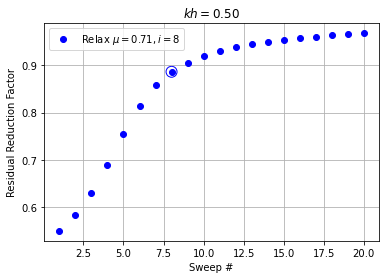

In [339]:
_LOGGER.info("kh {}".format(kh))
x_log = []
r_log = []
work = 1

_LOGGER.info("Relax at level {} size {}".format(finest, level.size))
b = np.zeros((a.shape[0], num_examples))

factor, num_sweeps, residual, conv, rer, relax_conv_factor = hm.solve.smoothing.shrinkage_factor(
    operator, lambda x, b: level.relax(x, b), (a.shape[0], ), 
    print_frequency=1, max_sweeps=20, slow_conv_factor=1.1, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))

title = "Relax"
color = "blue"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_sweeps]), num_sweeps, work, np.mean(residual[num_sweeps] / residual[0]) ** (1/(num_sweeps * work))))
ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

In [340]:
# Generate relaxed vectors.
# TODO(orenlivne): generalize to d-dimensions. This is specific to 1D.
level = multilevel[0]
x = hm.solve.run.random_test_matrix((level.size,), num_examples=num_examples)
# Improve vectors with 1-level relaxation.
_LOGGER.info("Random Start")
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

_LOGGER.info("Generating {} TVs with {} sweeps".format(x.shape[1], num_sweeps))
x, _ = hm.solve.run.run_iterative_method(
    level.operator, lambda x: level.relax(x, b), x, num_sweeps=num_sweeps)
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Random Start
INFO     RER 3.039
INFO     Generating 3 TVs with 8 sweeps
INFO     RER 0.343


### Coarsening

In [391]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

In [342]:
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

In [343]:
def create_coarsening(x, aggregate_size, num_components):
    # Construct coarsening on an aggregate.
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()

    # Tile the same coarsening over all aggregates.
    r, s = hm.setup.coarsening_uniform.create_coarsening(x_aggregate_t, num_components)
    return hrc.Coarsener(r)

def plot_coarsening(R, x):
    xc = R.dot(x)
    display(pd.DataFrame(R[:5,:10].todense()))

    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    ax = axs[0]
    for i in range(2):
        ax.plot(x[:, i])
    ax.set_title("$x$")
    ax.grid(True);

    ax = axs[1]
    for i in range(2):
        ax.plot(xc[::2, i])
    ax.set_title("$x^c$ Species 0")
    ax.grid(True);


    ax = axs[2]
    for i in range(2):
        ax.plot(xc[1::2, i])
    ax.set_title("$x^c$ Species 1")
    ax.grid(True);

def mock_conv_factor_for_domain_size(kh, r, aggregate_size, domain_size, nu_values):
    """Returns thre mock cycle conv factor for a domain of size m instead of n."""
    # Create fine-level matrix.
    a = hm.linalg.helmholtz_1d_operator(kh, domain_size)
    # Use default Kacmzarz for kh != 0.
    local_level = hm.setup.hierarchy.create_finest_level(a, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    r_csr = r.tile(domain_size // aggregate_size)
    return np.array([hm.setup.auto_setup.mock_cycle_conv_factor(local_level, r_csr, nu) for nu in nu_values])

,0,1,2,3,4,5,6,7,8,9
0,0.46,0.63,0.55,0.30,0.00,0.00,0.00,0.00,0.00,0.00
1,0.64,0.14,-0.34,-0.68,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.46,0.63,0.55,0.30,0.00,0.00
3,0.00,0.00,0.00,0.00,0.64,0.14,-0.34,-0.68,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.63


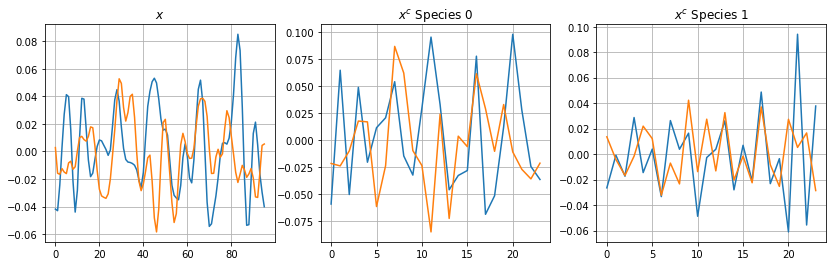

In [344]:
r = create_coarsening(x, aggregate_size, num_components)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
On a domain of size $4 a$, $a$ = aggregate size.

In [345]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 4
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = mock_conv_factor_for_domain_size(kh, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv factor {}".format(
    np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv factor [0.473 0.236 0.121 0.132 0.097 0.066 0.058 0.036]


### Interpolation
Using $P = R^T$ to start.

In [346]:
# caliber = 2
# interpolation_method = "svd"
# neighborhood = "extended"

# p = create_interpolation(
#     x_level, level.a, r, interpolation_method, aggregate_size=aggregate_size, nc=num_components, 
#     neighborhood=neighborhood, repetitive=repetitive, target_error=target_error,
#     caliber=caliber)

# for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
#     error = norm(x_set - p.dot(r.dot(x_set)), axis=0) / norm(x_set, axis=0)
#     error_a = norm(level.a.dot(x_set - p.dot(r.dot(x_set))), axis=0) / norm(x_set, axis=0)
#     _LOGGER.info(
#         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
#             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

In [347]:
def create_two_level_hiearchy(kh, m, r, p):
    a = hm.linalg.helmholtz_1d_operator(kh, m)
    r_csr = r.tile(m // aggregate_size)
    p_csr = hm.linalg.tile_array(p, m // aggregate_size)
    level0 = hm.setup.hierarchy.create_finest_level(a) #, relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
    level1 = hm.setup.hierarchy.create_coarse_level(level0.a, level0.b, r_csr, p_csr)
    multilevel = hm.hierarchy.multilevel.Multilevel.create(level0)
    multilevel.add(level1)
    return multilevel

def two_level_conv_factor(multilevel, nu, print_frequency: int = None):
    level = multilevel.finest_level
    n = level.size
    # Test two-level cycle convergence for A*x=b with random b.
    b = np.random.random((n, ))
    two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
    residual = lambda x: b - multilevel[0].operator(x)
    return hm.solve.run.run_iterative_method(
        residual, two_level_cycle, np.random.random((n, )), 15, print_frequency=print_frequency)

In [348]:
# P = R^T on a single aggregate.
p = r.tile(1).transpose()
print(p.todense())

[[ 0.462  0.638]
 [ 0.63   0.144]
 [ 0.55  -0.339]
 [ 0.295 -0.676]]


### Local Two-level Cycle (L2C) Rate

In [349]:
nu = 2
local_multilevel = create_two_level_hiearchy(kh, m * aggregate_size, r, p)
y, _ = two_level_conv_factor(local_multilevel, nu, print_frequency=1)

INFO         0 |r| 2.764e+00 RER 1.11370
INFO         1 |r| 3.878e+00 (1.40280) RER 0.31749 (0.28507) 12.214
INFO         2 |r| 1.720e+00 (0.44345) RER 0.21813 (0.68705) 7.883
INFO         3 |r| 4.224e-01 (0.24563) RER 0.04965 (0.22763) 8.507
INFO         4 |r| 1.385e-01 (0.32801) RER 0.01592 (0.32057) 8.704
INFO         5 |r| 4.500e-02 (0.32480) RER 0.00524 (0.32929) 8.586
INFO         6 |r| 9.927e-03 (0.22060) RER 0.00115 (0.22025) 8.599
INFO         7 |r| 5.717e-03 (0.57590) RER 0.00066 (0.57570) 8.602
INFO         8 |r| 2.495e-03 (0.43644) RER 0.00029 (0.43644) 8.602
INFO         9 |r| 1.129e-03 (0.45256) RER 0.00013 (0.45260) 8.601
INFO        10 |r| 5.287e-04 (0.46822) RER 0.00006 (0.46820) 8.601
INFO        11 |r| 2.470e-04 (0.46719) RER 0.00003 (0.46719) 8.601
INFO        12 |r| 1.100e-04 (0.44525) RER 0.00001 (0.44525) 8.601
INFO        13 |r| 4.612e-05 (0.41934) RER 0.00001 (0.41933) 8.601
INFO        14 |r| 1.880e-05 (0.40759) RER 0.00000 (0.40760) 8.601
INFO        15 |r| 7

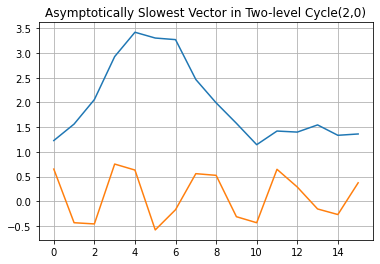

In [350]:
# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = y - local_multilevel[1].p.dot(local_multilevel[1].r.dot(y))
plt.plot(y);
plt.plot(e);
plt.grid(True);

In [351]:
two_level_conv = np.array([
    two_level_conv_factor(create_two_level_hiearchy(kh, m * aggregate_size, r, p), nu)[1]
     for nu in nu_values])

conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "Two-level"))
display(conv)

,Mock,Two-level
1,0.47,0.51
2,0.24,0.47
3,0.12,0.50
4,0.13,0.70
5,0.10,0.66
6,0.07,0.57
7,0.06,0.53
8,0.04,0.52


This intepolation is good up to $\nu = 2$, conv $\approx 0.35$.

<!-- ### Build Coarse Level: Two-level Bootstrap Cycle -->

In [352]:
# max_levels = 2
# num_bootstrap_steps = 1

# # Bootstrap with an increasingly deeper hierarchy (add one level at a time).
# num_levels = 2
# _LOGGER.info("bootstrap on grid size {} with {} levels".format(x.shape[0], max_levels))
# _LOGGER.info("-" * 80)
# for i in range(num_bootstrap_steps):
#     _LOGGER.info("Bootstrap step {}/{}".format(i + 1, num_bootstrap_steps))
#     # Set relax_conv_factor to a high value so that we never append a bootstrap vector to the TV set.
#     x, multilevel = hm.setup.auto_setup.bootstap(
#         x, multilevel, num_levels, 2.0,
#         num_sweeps=num_sweeps, interpolation_method=interpolation_method, 
#         neighborhood=neighborhood, repetitive=repetitive, target_error=0.1)
#     x_log.append(x)
#     r_log.append(multilevel[1].r)
#     _LOGGER.info("RER {:.6f}".format(norm(a.dot(x)) / norm(x)))
#     _LOGGER.info("-" * 80)

### Two-level Hierarchy

In [353]:
multilevel = hm.hierarchy.multilevel.Multilevel.create(level)
l = 1
r_csr = r.tile(n // aggregate_size)
p_csr = r_csr.transpose()
level1 = hm.setup.hierarchy.create_coarse_level(level.a, level.b, r_csr, p_csr)
_LOGGER.info("Level {} size {}".format(l, level1.size))
multilevel.add(level1)

INFO     Level 1 size 48


#### Level 0

In [354]:
pd.DataFrame(multilevel[0].a.tocsr()[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00,0.00
2,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00,0.00
3,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00,0.00
4,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00,0.00
5,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00,0.00
6,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08,0.00
7,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33,-0.08
8,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25,1.33
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.08,1.33,-2.25


#### Level 1

In [355]:
pd.DataFrame(multilevel[1].a[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,-0.19,-0.17,0.15,0.22,0.00,0.00,0.00,0.00,0.00,0.00
1,-0.17,-1.47,-0.37,-0.55,0.00,0.00,0.00,0.00,0.00,0.00
2,0.15,-0.37,-0.19,-0.17,0.15,0.22,0.00,0.00,0.00,0.00
3,0.22,-0.55,-0.17,-1.47,-0.37,-0.55,0.00,0.00,0.00,0.00
4,0.00,0.00,0.15,-0.37,-0.19,-0.17,0.15,0.22,0.00,0.00
5,0.00,0.00,0.22,-0.55,-0.17,-1.47,-0.37,-0.55,0.00,0.00
6,0.00,0.00,0.00,0.00,0.15,-0.37,-0.19,-0.17,0.15,0.22
7,0.00,0.00,0.00,0.00,0.22,-0.55,-0.17,-1.47,-0.37,-0.55
8,0.00,0.00,0.00,0.00,0.00,0.00,0.15,-0.37,-0.19,-0.17
9,0.00,0.00,0.00,0.00,0.00,0.00,0.22,-0.55,-0.17,-1.47


In [356]:
pd.DataFrame(multilevel[1].p[:10, :10].todense())

,0,1,2,3,4,5,6,7,8,9
0,0.46,0.64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.63,0.14,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.55,-0.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.30,-0.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.46,0.64,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.63,0.14,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.55,-0.34,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.30,-0.68,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.46,0.64,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.63,0.14,0.00,0.00,0.00,0.00


In [357]:
pd.DataFrame(multilevel[1].r[:10,:10].todense())

,0,1,2,3,4,5,6,7,8,9
0,0.46,0.63,0.55,0.30,0.00,0.00,0.00,0.00,0.00,0.00
1,0.64,0.14,-0.34,-0.68,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.46,0.63,0.55,0.30,0.00,0.00
3,0.00,0.00,0.00,0.00,0.64,0.14,-0.34,-0.68,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.46,0.63
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.14
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Coarse-level Relaxation Shrinkage

INFO     Relax at level 1 size 48
INFO     Iter     |r|                         |x|         RER
INFO     0     5.393e-01                    4.469e-01    1.208
INFO     1     1.641e-01 (0.307) [0.307]    3.321e-01    0.498 (0.413)
INFO     2     9.006e-02 (0.551) [0.411]    3.075e-01    0.298 (0.597)
INFO     3     8.033e-02 (0.893) [0.533]    2.944e-01    0.276 (0.934)
INFO     4     7.363e-02 (0.917) [0.610]    2.833e-01    0.264 (0.954)
INFO     5     6.804e-02 (0.924) [0.663]    2.731e-01    0.253 (0.960)
INFO     6     6.322e-02 (0.929) [0.701]    2.638e-01    0.244 (0.963)
INFO     7     5.887e-02 (0.931) [0.730]    2.554e-01    0.235 (0.963)
INFO     8     5.495e-02 (0.934) [0.753]    2.478e-01    0.227 (0.964)
INFO     9     5.140e-02 (0.936) [0.771]    2.409e-01    0.219 (0.964)
INFO     10    4.820e-02 (0.938) [0.786]    2.346e-01    0.211 (0.964)
INFO     11    4.531e-02 (0.940) [0.799]    2.289e-01    0.204 (0.965)
INFO     12    4.270e-02 (0.943) [0.810]    2.237e-01    0.1

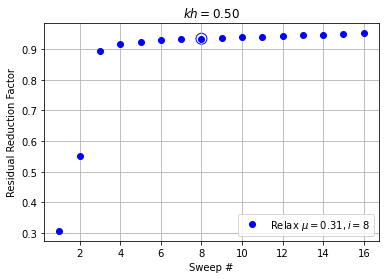

In [358]:
work = 1
l = 1
level = multilevel[l]
_LOGGER.info("Relax at level {} size {}".format(l, level.size))
b = np.zeros((level.size, num_examples))

factor, num_coarse_sweeps, residual, conv, rer, relax_conv_factor = \
    hm.solve.smoothing.shrinkage_factor(
        level.operator, lambda x, b: level.relax(x, b), (level.size, ), 
        print_frequency=1, max_sweeps=20, slow_conv_factor=0.95, leeway_factor=leeway_factor)
_LOGGER.info("Relax conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {} sweeps. Work {:.1f} eff {:.2f}".format(
    relax_conv_factor, factor, np.mean(rer[num_coarse_sweeps]), num_coarse_sweeps, work, np.mean(residual[num_coarse_sweeps] / residual[0]) ** (1/(num_coarse_sweeps * work))))

title = "Relax"
color = "blue"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hm.solve.smoothing.plot_diminishing_returns_point(factor, num_sweeps, conv, ax, title=title, color=color)
print("{:<5s} conv {:.2f} shrinkage {:.2f} PODR RER {:.2f} after {:>2d} sweeps. Work {:>2d} efficiency {:.2f}".format(
    title, conv_factor, factor, np.mean(rer[num_coarse_sweeps]), num_coarse_sweeps, work, np.mean(residual[num_coarse_sweeps] / residual[0]) ** (1/(num_coarse_sweeps * work))))
ax.set_title(r"$kh = {:.2f}$".format(kh))
ax.legend();

### Relaxation Cycle Shrinkage
We compare relaxation cycle with $\nu_1=2, \nu_2=2, \nu_{coarse}=20$ with the resulting $P$ and $R$ from the bootstrap step, with Kaczmarz relaxation.

INFO     Iter     |r|                         |x|         RER
INFO     0     1.357e+00                    4.471e-01    3.035
INFO     1     7.301e-01 (0.538) [0.538]    3.401e-01    2.151 (0.708)
INFO     2     4.178e-01 (0.573) [0.555]    2.933e-01    1.431 (0.665)
INFO     3     2.575e-01 (0.617) [0.575]    2.709e-01    0.956 (0.668)
INFO     4     1.724e-01 (0.670) [0.598]    2.582e-01    0.672 (0.703)
INFO     5     1.275e-01 (0.740) [0.624]    2.499e-01    0.514 (0.765)
INFO     6     1.016e-01 (0.797) [0.650]    2.438e-01    0.419 (0.817)
INFO     7     8.659e-02 (0.852) [0.676]    2.390e-01    0.364 (0.869)
INFO     8     7.654e-02 (0.884) [0.699]    2.349e-01    0.327 (0.899)
INFO     9     6.945e-02 (0.907) [0.719]    2.314e-01    0.302 (0.921)
INFO     Relax conv 0.91 shrinkage 0.70 PODR RER 0.33 after 8 sweeps. Work 1.0 eff 0.70
INFO     Iter     |r|                         |x|         RER
INFO     0     1.279e+00                    4.463e-01    2.867
INFO     1     1.235e-0

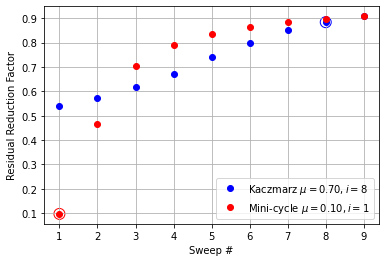

In [359]:
slow_conv_factor = 0.9
nu_pre, nu_post, nu_coarsest = num_sweeps, 0, max(3, num_coarse_sweeps)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, nu_pre=nu_pre, nu_post=nu_post, nu_coarsest=nu_coarsest, leeway_factor=leeway_factor, slow_conv_factor=slow_conv_factor)
num_mini_cycles = method_info["Mini-cycle"][2].shape[0]
_LOGGER.info("Two-level ({}, {}; {}) relaxation cycle is slow after {} steps".format(
    nu_pre, nu_post, nu_coarsest, num_min_cycles))

### Improve Test Vectors by Relaxation Cycles

In [360]:
def relax_cycle(x):
    return hm.solve.relax_cycle.relax_cycle(multilevel, 1.0, nu_pre, nu_post, nu_coarsest).run(x)

level = multilevel[0]
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
_LOGGER.info("Improving vectors by {} relaxation cycles".format(num_mini_cycles))
x, _ = hm.solve.run.run_iterative_method(level.operator, relax_cycle, x, num_mini_cycles)
_LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     RER 0.343
INFO     Improving vectors by 10 relaxation cycles
INFO     RER 0.203


Step  0 s [1.    0.86  0.745 0.543] Energy error [0.784 0.573 0.338 0.   ]
Step  1 s [1.    0.669 0.128 0.048] Energy error [0.564 0.113 0.04  0.   ]
Step  2 s [1.    0.503 0.034 0.025] Energy error [0.45  0.037 0.022 0.   ]


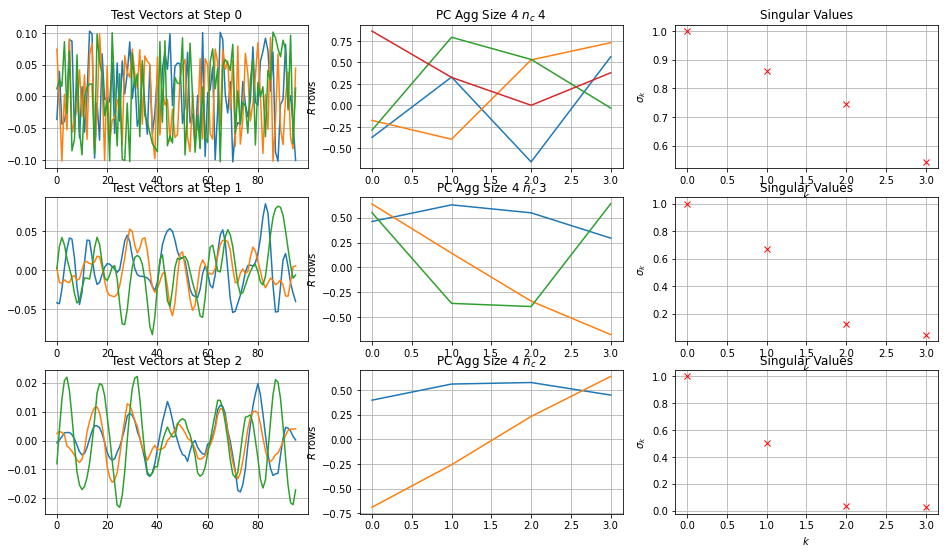

In [372]:
aggregate_size = 4
threshold = 0.1
fig, axs = plt.subplots(len(x_log), 3, figsize=(16, 3 * len(x_log)))
for row, x in enumerate(x_log):
    x_aggregate_t = np.concatenate(
        tuple(hm.linalg.get_window(x, offset, aggregate_size)
              for offset in range(max((4 * aggregate_size) // x.shape[1], 1))), axis=1).transpose()    
#     start, end = 0, aggregate_size
#     x_aggregate_t = x[start:end].transpose()
    r, s = hrc.create_coarsening(x_aggregate_t, threshold)
    r = r.asarray()

    # Relaxed vectors.
    ax = axs[row, 0]
    for i in range(3):
        ax.plot(x[:, i]);
    ax.grid(True)
    ax.set_title(r"Test Vectors at Step {}".format(row))

    ax = axs[row, 1]
    # R should be real-valued, but cast just in case.
    for i, ri in enumerate(np.real(r)):
        ax.plot(ri)
    ax.set_title(r"PC Agg Size {} $n_c$ {}".format(r.shape[1], r.shape[0]))
    ax.set_ylabel(r"$R$ rows")
    ax.grid(True);

    # Singular values, normalized to sigma_max = 1.
    ax = axs[row, 2]
    ax.plot(s / s[0], "rx")
    ax.set_title("Singular Values")
    ax.set_xlabel(r"$k$")
    ax.set_ylabel(r"$\sigma_k$")
    ax.grid(True);
    
    print("Step {:2d}".format(row), "s", s / s[0], "Energy error", (1 - np.cumsum(s ** 2) / sum(s ** 2)) ** 0.5)

## Alignment

INFO     Local alignment
0  +4.635857 1.767920e-03 4.909599e-05 ( 36.01) [0.017 0.038]
2  +4.013341 3.123972e-03 2.447723e-04 ( 12.76) [0.055 0.009]
4  +4.641068 1.764131e-03 4.440979e-04 (  3.97) [0.034 0.024]
6  +4.536346 2.409352e-03 5.328308e-04 (  4.52) [0.044 0.021]
8  +4.204065 3.693311e-03 4.663867e-04 (  7.92) [0.057 0.022]
10 +4.806096 2.614204e-03 5.642846e-04 (  4.63) [0.041 0.031]
12 +4.034599 5.248998e-03 2.817121e-04 ( 18.63) [0.069 0.022]
14 +4.820659 2.209661e-03 2.951829e-04 (  7.49) [0.028 0.038]
16 +4.127239 2.689415e-03 3.486655e-04 (  7.71) [0.047 0.021]
18 +4.815160 1.217733e-03 5.140720e-04 (  2.37) [0.032 0.014]
20 +4.674081 7.049662e-04 1.516407e-04 (  4.65) [0.018 0.019]
22 +4.743828 7.188489e-04 4.983939e-04 (  1.44) [0.026 0.006]
24 +4.709356 4.431442e-04 8.689969e-05 (  5.10) [0.016 0.014]
26 +4.986937 7.260017e-04 5.277143e-04 (  1.38) [0.025 0.01 ]
28 +4.416717 1.056745e-03 1.826316e-04 (  5.79) [0.029 0.015]
30 +4.869388 1.433488e-03 6.486212e-04 (  2.2

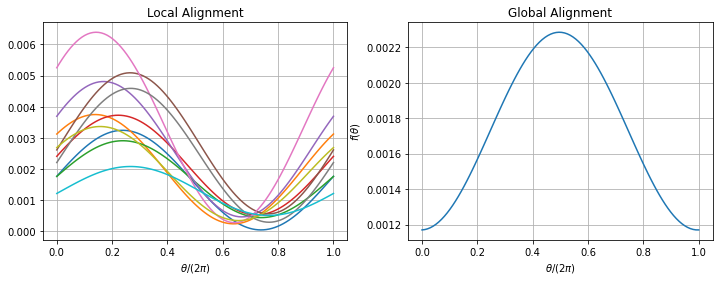

In [390]:
level = multilevel[0]
coarse_level = multilevel[1]
xc = coarse_level.coarsen(x)

# Local alignment.
_LOGGER.info("Local alignment")
phi = hm.setup.alignment.calculate_local_rotation_angles(level.size, aggregate_size, num_components, xc)

# Global alignment.
_LOGGER.info("Global alignment")
f, tmin = hm.setup.alignment.optimal_rotation_angle(xc)

# Plot f(theta).
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
hm.setup.alignment.plot_min_functions(n, aggregate_size, num_components, xc, ax)
ax.set_title("Local Alignment");

ax = axs[1]
t = np.linspace(0, 2 * np.pi, 100)
ax.plot(t / (2 * np.pi), np.array([f(theta) for theta in t]))
ax.grid(True);
ax.set_xlabel(r"$\theta / (2 \pi)$")
ax.set_ylabel(r"$f(\theta)$");
ax.set_title("Global Alignment");

It looks like global alignment doesn't reduce the distance at all, but local alignment can be a significant factor, and the minmiizing angles are all in a similar region, intersecting at around $\theta = -0.35 \pi$.

<!-- ### Solving $A x = b$ (Periodic Fixed-Size Domain Problem)
That is, solving on a periodic fixed d
omain. $b$ is a random periodic vector. We start from random $x$. Solving exactly on the coarsest level works fine despite the indefiniteness since the matrix is not (even nearly) singular. -->

In [361]:
# level = multilevel.finest_level
# # Test two-level cycle convergence for A*x=0 and  A*x=b with random b.
# for title, b in (("0", np.zeros((a0.shape[0], ))), ("b", np.random.random((a0.shape[0], )))):
#     logger.info("Ax={}".format(title))
#     two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 2, 1, nu_coarsest=-1, debug=False, rhs=b).run(y)
#     residual = lambda x: b - multilevel[0].operator(x)
#     x, conv_factor = hm.solve.run.run_iterative_method(residual, two_level_cycle, np.random.random((a0.shape[0], )), 20, print_frequency=1)

In [362]:
# # Asymptotic vector.
# e = x - multilevel[1].p.dot(multilevel[1].r.dot(x))
# plt.plot(x);
# plt.plot(e);

In [363]:
# # L2 interpolation error
# logger.info("|x-P*R*x|     {:.2e}".format(hm.linalg.scaled_norm(e)))
# logger.info("|x|           {:.2e}".format(hm.linalg.scaled_norm(x)))

# # Residual norm interpolation error
# logger.info("|A*(x-P*R*x)| {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(e))))
# logger.info("|Ax|          {:.2e}".format(hm.linalg.scaled_norm(multilevel[0].a.dot(x))))

In [364]:
# nu_values = np.arange(1, 7, dtype=int)
# r = multilevel[1].r
# two_level_cycle = lambda y: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, 1, 0, nu_coarsest=-1, debug=False, rhs=b).run(y)
# residual = lambda x: b - multilevel[0].operator(x)
# b = np.random.random((a0.shape[0], ))
# mock_conv_factor = np.array([
#     hm.setup.auto_setup.mock_cycle_conv_factor(multilevel.finest_level, r, nu) 
#     for nu in nu_values])
# two_level_cycle = np.array([
#     hm.solve.run.run_iterative_method(
#         residual, 
#         lambda x: hm.solve.solve_cycle.solve_cycle(multilevel, 1.0, nu, 0, nu_coarsest=-1, rhs=b).run(x), 
#         np.random.random((multilevel.finest_level.size, )), 20)[1]
#     for nu in nu_values])

# for nu, mock, two_level in zip(nu_values, mock_conv_factor, two_level_cycle):
#     print("V({}, {}) conv factor {:.3f} mock cycle {:.3f}".format(nu, 0, two_level, mock))

<!-- For some reason, 1 relaxation per cycle is more efficient than $2-4$ per cycle! Note that we are solving $Ax=b$, not $Ax=0$. -->

## Spectra of Different Levels

In [365]:
# # Calculate eigenpairs at all levels.
# vl = []
# laml = []
# for l, level in enumerate(multilevel):
#     a = level.a
#     lam, v = eig(a.todense())
#     lam = np.real(lam)
#     ind = np.argsort(np.abs(lam))
#     lam = lam[ind]
#     v = v[:, ind]
#     vl.append(v)
#     laml.append(lam)
#     print(l, "lam", lam[:13])
    
# # Interpolate eigenvectors at all levels to the finest level.
# num_levels = len(multilevel)
# vl_finest = []
# for l in range(num_levels):
#     v = vl[l]
#     for k in range(l, 0, -1):
#         v = multilevel[k].p.dot(v)
#     vl_finest.append(v)

In [366]:
# num_ev = 8
# num_levels = len(multilevel)
# fig, axs = plt.subplots(num_ev, num_levels, figsize=(16, 16))

# for col, ax in enumerate(axs[0]):
#     ax.set_title("Level {}".format(col))

# for i in range(num_ev):
#     for l in range(num_levels):
#         ax = axs[i, l]
#         ax.plot(np.real(vl[l][:, i]), label="$\lambda_i = {:.3f}$".format(laml[l][i]))
#         ax.legend(loc="upper right")
#         ax.grid(True);